# Routing Optimization - Optimization Model

Project student team: Peter Pan; Vincent Pan; Sanjit Sokhi, Jerry Wang, Jiadi Zhang

Advisor: Amr Farahat

Creation date: 2023-03-27

This jupyter notebook simulates the driver location data and transportation order data. To protect company privacy, the probability distributions of the simulated time windows, revenue, and zipcodes are completed different from the real company data. The bottom of the notebook shows a sample of the simulated data. 


In [414]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import datetime, timedelta
import numpy as np
from geopy.geocoders import Nominatim 
from geopy import distance 
from multidict import MultiDict
import math
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns
import random

In [415]:
def zip_correcter(zipcodes):
    zipdf = zipcodes.copy()
    corrected_zips = []
    for azip in zipdf:
        zip_length = len(str(azip))
        if zip_length < 5:
            corrected_zips.append((5-zip_length)*'0' + str(azip))
        elif zip_length > 5:
            corrected_zips.append(str(azip)[:5])
        else:
            corrected_zips.append(azip)
    return corrected_zips

In [416]:
df = pd.read_csv("order_data.csv",dtype={'dest_zipcode':str,'origin_zipcode':str})
samp_data =pd.read_csv('SampleData_3Months.csv')
df['dest_zipcode'] = zip_correcter(df['dest_zipcode'])
df['origin_zipcode'] = zip_correcter(df['origin_zipcode'])

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_2556\3145525872.py:2: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  samp_data =pd.read_csv('SampleData_3Months.csv')


In [417]:
df = df.sample(n=10000, replace=True, random_state=42)

In [418]:
df = pd.merge(df,samp_data[['OrderNo','LineHaulRevenue','DispatchMiles']],left_on = 'order_id', right_on = 'OrderNo',how = 'left')

In [419]:
mean = 3000
std_dev = 1000
num_samples = 2103
df['LineHaulRevenue'] = np.random.normal(loc=mean, scale=std_dev, size=len(df))

<AxesSubplot:xlabel='LineHaulRevenue', ylabel='Count'>

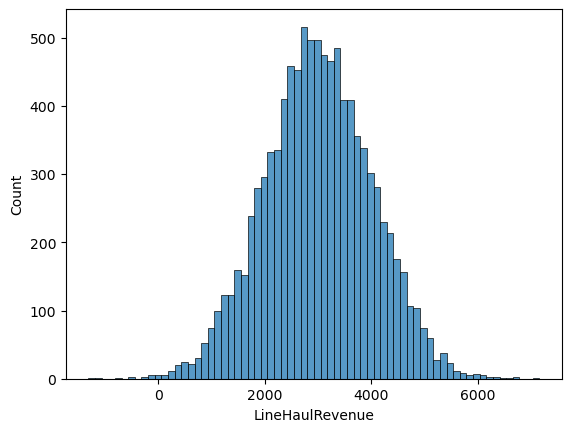

In [420]:
sns.histplot(data=df, x="LineHaulRevenue")


In [421]:
new_order_id = []
for new_id, order_id in enumerate(df['order_id']):
    new_order_id.append(new_id)
df['order_id'] = new_order_id

In [422]:
zips = pd.read_csv('uszips.csv', dtype={'zip':str})
zips['zip'] = zip_correcter(zips['zip'])
zips['zip'] = zips['zip'].astype(str)

In [423]:
num_samples = len(df)

df['dest_zipcode'] = zips['zip'].sample(n=num_samples, replace=True, random_state=42).reset_index(drop = True)
df['origin_zipcode'] = zips['zip'].sample(n=num_samples, replace=True, random_state=43).reset_index(drop = True)


In [424]:
df = df.drop('OrderNo', axis = 1)

In [425]:
columns = ['pickup_window_start','pickup_window_end','delivery_window_start','delivery_window_end']

In [426]:
for column in df[columns]:
    df[column] = pd.to_datetime(df[column])
    

In [427]:
# Calculate the hour difference
reference_date = pd.to_datetime('2/1/2023 0:00')
df['hour_difference'] = (df['pickup_window_start'] - reference_date).dt.total_seconds() / 3600


In [428]:
df['reference_date'] = pd.to_datetime('2/1/2023 0:00')

In [429]:
df['delivery_window_end'] = pd.to_datetime(df['delivery_window_end'])

# Filter the dataframe based on the date column
df = df[df['delivery_window_end'] < '2023-02-08 00:00'].reset_index()

In [430]:
length = len(df)
columns2 = ['reference_date','pickup_window_start','pickup_window_end','delivery_window_start','delivery_window_end']
columns3 = ['pickup_window_start','pickup_window_end','delivery_window_start','delivery_window_end','bad_column']
time_package = (np.random.normal(50, 40, length), np.random.normal(10, 7, length), np.random.normal(50, 30,length), np.random.normal(10, 7, length), np.random.normal(0, 0, length))
for column2, column3, distribution in zip(columns2, columns3, time_package):
    df[column3] = df[column2] + pd.Series(pd.to_timedelta(distribution, unit='h'))

In [431]:
for column in columns:
    df[column] = pd.to_datetime(df[column])
    df[column] = df[column].apply(lambda x: x.strftime('%m-%d-%Y %H:%M'))
    df[column] = df[column].astype(str)
    df[column] = df[column].apply(lambda x: x.replace('-', '/'))

In [432]:
df = df.drop(['reference_date','bad_column','hour_difference'], axis = 1)

In [433]:
df.to_csv('C:/Users/jiadiz/Desktop/PGT Trucking/initial model/Github/simulated_order_sample.csv',index = False)

In [434]:
md = pd.read_csv('driver_data.csv', dtype={'depot_zipcode':str})

In [435]:
md['depot_zipcode'] = zips['zip'].sample(n=len(md), replace=True, random_state=42).reset_index(drop = True)

In [436]:
lista = []
for i in range(0,len(md)):
    lista.append(('Driver'+ str(i)))
md['driver_id'] = lista

In [437]:
md.to_csv('C:/Users/jiadiz/Desktop/PGT Trucking/initial model/Github/simulated_driver_sample.csv',index = False)

In [438]:
md

,driver_id,depot_zipcode,radius_origins
0,Driver0,47362,NaN
1,Driver1,03307,NaN
2,Driver2,33965,NaN
3,Driver3,19806,NaN
4,Driver4,49654,NaN
...,...,...,...
549,Driver549,38565,NaN
550,Driver550,54111,NaN
551,Driver551,97140,NaN
552,Driver552,30157,NaN


In [439]:
df

,index,order_id,origin_zipcode,dest_zipcode,pickup_window_start,pickup_window_end,delivery_window_start,delivery_window_end,LineHaulRevenue,DispatchMiles
0,0,0,43221,47362,01/31/2023 21:16,02/01/2023 11:50,02/04/2023 05:40,02/04/2023 04:21,4222.564310,834
1,2,2,54228,33965,02/04/2023 01:50,02/04/2023 12:30,02/05/2023 16:34,02/05/2023 17:48,2031.684033,905
2,4,4,17007,49654,02/03/2023 21:09,02/04/2023 08:59,02/07/2023 03:37,02/07/2023 16:10,3924.337235,178
3,5,5,80474,62543,02/03/2023 20:59,02/03/2023 16:39,02/04/2023 00:53,02/04/2023 09:55,2920.966173,374
4,6,6,48444,47946,01/31/2023 22:31,01/31/2023 23:31,02/01/2023 20:57,02/01/2023 21:54,4082.072974,357
...,...,...,...,...,...,...,...,...,...,...
7856,9994,9994,78597,10924,01/31/2023 20:00,02/01/2023 04:46,02/03/2023 13:52,02/03/2023 21:31,2650.953078,429
7857,9996,9996,54140,56583,02/04/2023 03:30,02/04/2023 13:26,02/06/2023 02:42,02/06/2023 11:43,1216.809354,311
7858,9997,9997,16374,11233,02/02/2023 06:14,02/02/2023 04:29,02/04/2023 12:10,02/04/2023 20:46,1486.520395,333
7859,9998,9998,57270,69346,02/02/2023 05:36,02/02/2023 21:52,02/07/2023 07:33,02/07/2023 07:32,4134.050430,144
